<a href="https://colab.research.google.com/github/LucasCalbucuraZ/MOS/blob/main/tesis/MOS_3km_Tmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# MODEL OUTPUT STATISTICS (MOS) 
# Calibración de las series de tiempo históricas (construidas considerando las primeras 24 horas de pronóstico de cada día)

# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib import style
import seaborn as sns
import datetime
from datetime import datetime, timedelta

# Utilidades
# ==============================================================================
from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Cargamos los 704 datos diarios desde GitHub
# T2_max, T2_WRF_max, T2_min, T2_WRF_min, P_WRF_max, P_WRF_min, U10_WRF_max, U10_WRF_min, V10_WRF_max, V10_WRF_min
# ==============================================================================
CUCAO = pd.read_csv('https://raw.githubusercontent.com/LucasCalbucuraZ/MOS/main/data/CUCAO_diario_abs.csv'); 
MELINKA = pd.read_csv('https://raw.githubusercontent.com/LucasCalbucuraZ/MOS/main/data/MELINKA_diario_abs.csv'); 

# Se genera el vector fecha (desde el 1 de septiembre del 2020 al 1 de agosto de 2022)
# ==============================================================================
t = np.arange(np.datetime64('2020-09-01'), np.datetime64('2022-08-01'))
time= pd.to_datetime(t)

# Interpolamos los NaN para poder construir la regresión lineal múltiple  
# ==============================================================================
# CUCAO
T2_WRF_Max=CUCAO["T2_WRF_max"].interpolate(method='polynomial',order=2); CUCAO["T2_WRF_max"]=T2_WRF_Max.to_frame()
P_WRF_Max= CUCAO["P_WRF_max"].interpolate(method='polynomial', order=2);  CUCAO["P_WRF_max"]=P_WRF_Max.to_frame()
U10_WRF_Max= CUCAO["U10_WRF_max"].interpolate(method='polynomial', order=2);  CUCAO["U10_WRF_max"]=U10_WRF_Max.to_frame()
V10_WRF_Max= CUCAO["V10_WRF_max"].interpolate(method='polynomial', order=2); CUCAO["V10_WRF_max"]=V10_WRF_Max.to_frame()
del T2_WRF_Max; del P_WRF_Max; del U10_WRF_Max; del V10_WRF_Max; 
# ==============================================================================
# MELINKA
T2_WRF_Max = MELINKA["T2_WRF_max"].interpolate(method='polynomial',order=2); MELINKA["T2_WRF_max"]=T2_WRF_Max.to_frame()
P_WRF_Max  = MELINKA["P_WRF_max"].interpolate(method='polynomial', order=2);  MELINKA["P_WRF_max"]=P_WRF_Max.to_frame()
U10_WRF_Max= MELINKA["U10_WRF_max"].interpolate(method='polynomial', order=2); MELINKA["U10_WRF_max"]=U10_WRF_Max.to_frame()
V10_WRF_Max= MELINKA["V10_WRF_max"].interpolate(method='polynomial', order=2); MELINKA["V10_WRF_max"]=V10_WRF_Max.to_frame()
del T2_WRF_Max; del P_WRF_Max; del U10_WRF_Max; del V10_WRF_Max;

In [17]:
# División de los datos en train y test
ESTACION = MELINKA
predictores = ESTACION.filter(['T2_WRF_max','P_WRF_max','U10_WRF_max','V10_WRF_max'], axis=1)
predictores.columns=['T2','P','U10','V10']
#predictores.columns=['T2','P','U10','V10']

sc=StandardScaler()
predictores_std = sc.fit_transform(predictores)
predictors = pd.DataFrame(predictores_std, columns = ['T2','P','U10','V10'])


y = ESTACION['T2_max'] # Variable dependiente (en este caso son las observaciones, recordar que es un problema inverso)

# Acá dividimos los datos conservando el primer 90% para entrenar el modelo derivando los coeficientes de regresión y luego
# los aplicamos en el 10% no utilizado. Lo anterior también se conoce como validación cruzada (o cross-validation) y es la
# mejor forma de cuantificar la precisión o skill de MOS (o de cualquier predicción estadística..)
X_train, X_test, y_train, y_test = train_test_split(
                                        predictors,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.994,      # Entrenamiento considera hasta el 1 de agosto de 2022-
                                        shuffle      = False  # División lineal ya que los datos tienen un orden temporal
                                    )

# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit() #Entrena el algoritmo
print(modelo.summary())

# CUCAO :   0.896 , 0.896, 0.896, 0.900

# MELINKA : 0.877 , 0.887, 0.887, 0.894



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     1456.
Date:                Wed, 12 Apr 2023   Prob (F-statistic):               0.00
Time:                        01:13:43   Log-Likelihood:                -1253.4
No. Observations:                 699   AIC:                             2517.
Df Residuals:                     694   BIC:                             2540.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.6841      0.055    266.064      0.0

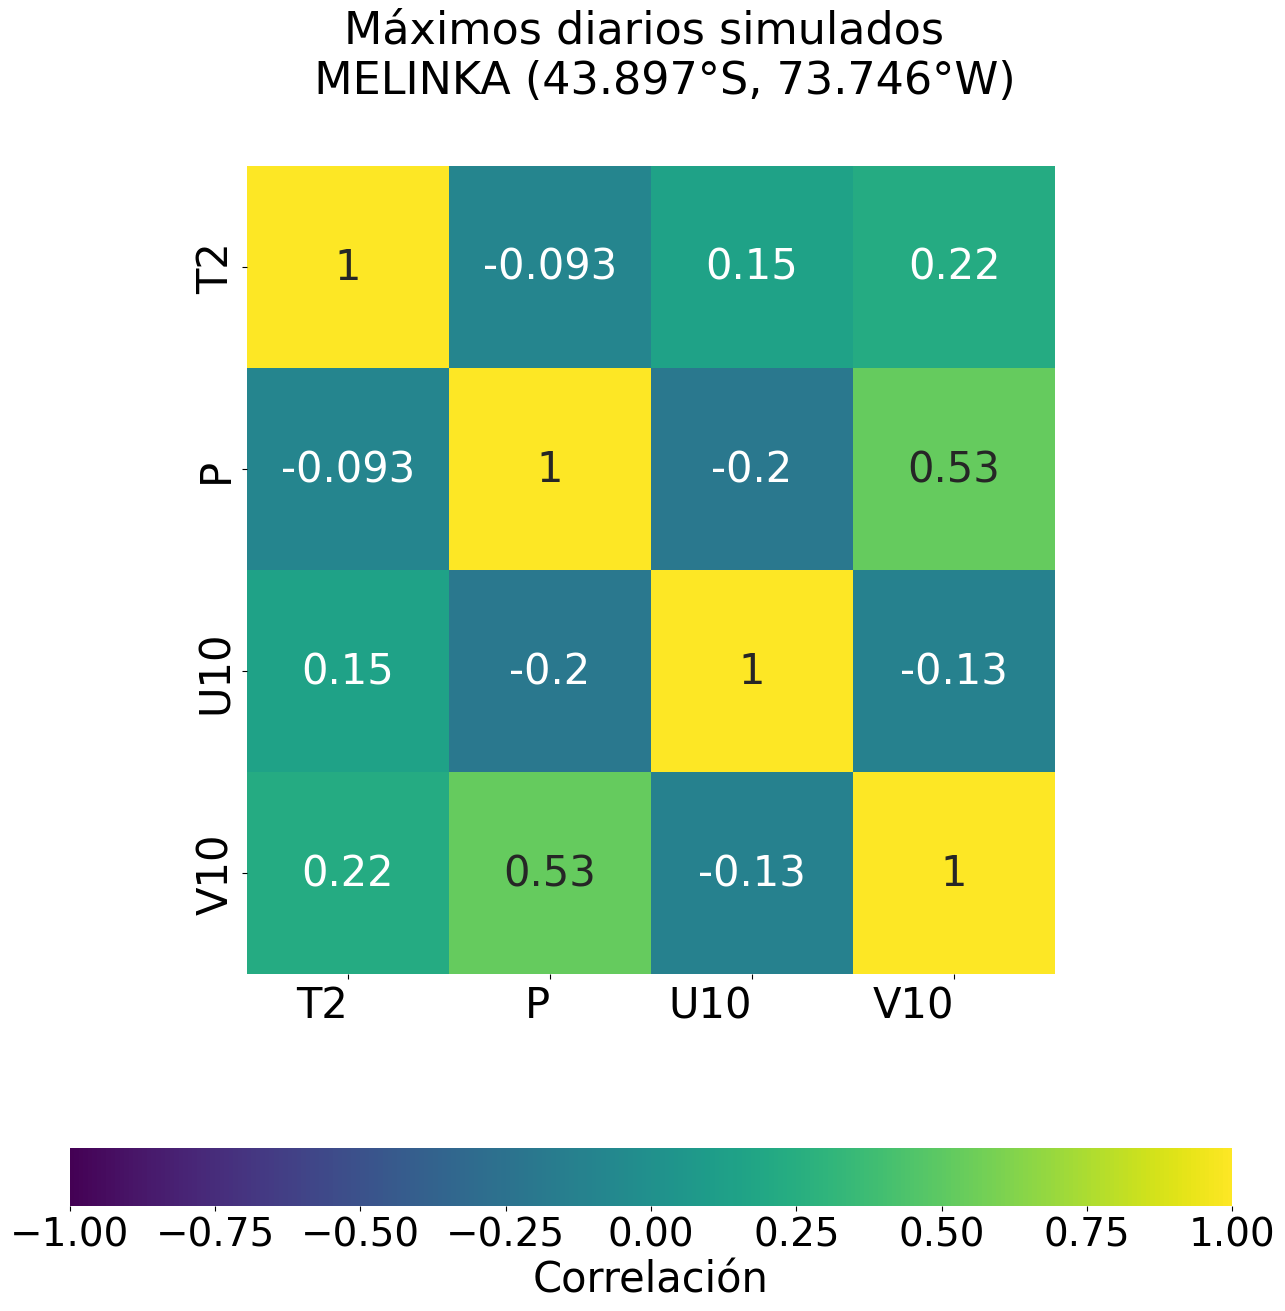

In [18]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para generar la matriz de correlación
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)

    return(corr_mat)

corr_matrix = predictores.select_dtypes(include=['float64', 'int']).corr(method='pearson')

# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
plt.title('Máximos diarios simulados \n  MELINKA (43.897°S, 73.746°W)',fontsize=32,y=1.08)
sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = True,
    cbar_kws = dict(use_gridspec=False,location="bottom"),
    annot_kws = {"size": 30},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.color_palette("viridis", as_cmap=True),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 0,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 30)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=28)
ax.collections[0].colorbar.set_label("Correlación",fontsize=30)
plt.savefig('MELINKA_heatmap_max.png')

In [15]:
# AJUSTANDO LA SERIE DE TIEMPO HISTÓRICA DE CUCAO
# ==============================================================================
predicciones_xtrain1 = modelo.predict(exog = X_train)
#predicciones_xtrain.isnull().sum().sum() #para revisar los NaN

In [16]:
reconstruccion_CUCAO=predicciones_xtrain1
OBS_CUCAO =y_train.flatten()
MOS_CUCAO = reconstruccion_CUCAO
residuos_CUCAO=MOS_CUCAO-OBS_CUCAO
WRF_CUCAO=CUCAO["T2_WRF_max"].iloc[0:699]

In [12]:
# AJUSTANDO LA SERIE DE TIEMPO HISTÓRICA DE MELINKA
# ==============================================================================
predicciones_xtrain2 = modelo.predict(exog = X_train)
#predicciones_xtrain.isnull().sum().sum() #para revisar los NaN

In [13]:
reconstruccion_MELINKA=predicciones_xtrain2
OBS_MELINKA =y_train.flatten()
MOS_MELINKA = reconstruccion_MELINKA
residuos_MELINKA=MOS_MELINKA-OBS_MELINKA
WRF_MELINKA=MELINKA["T2_WRF_max"].iloc[0:699]

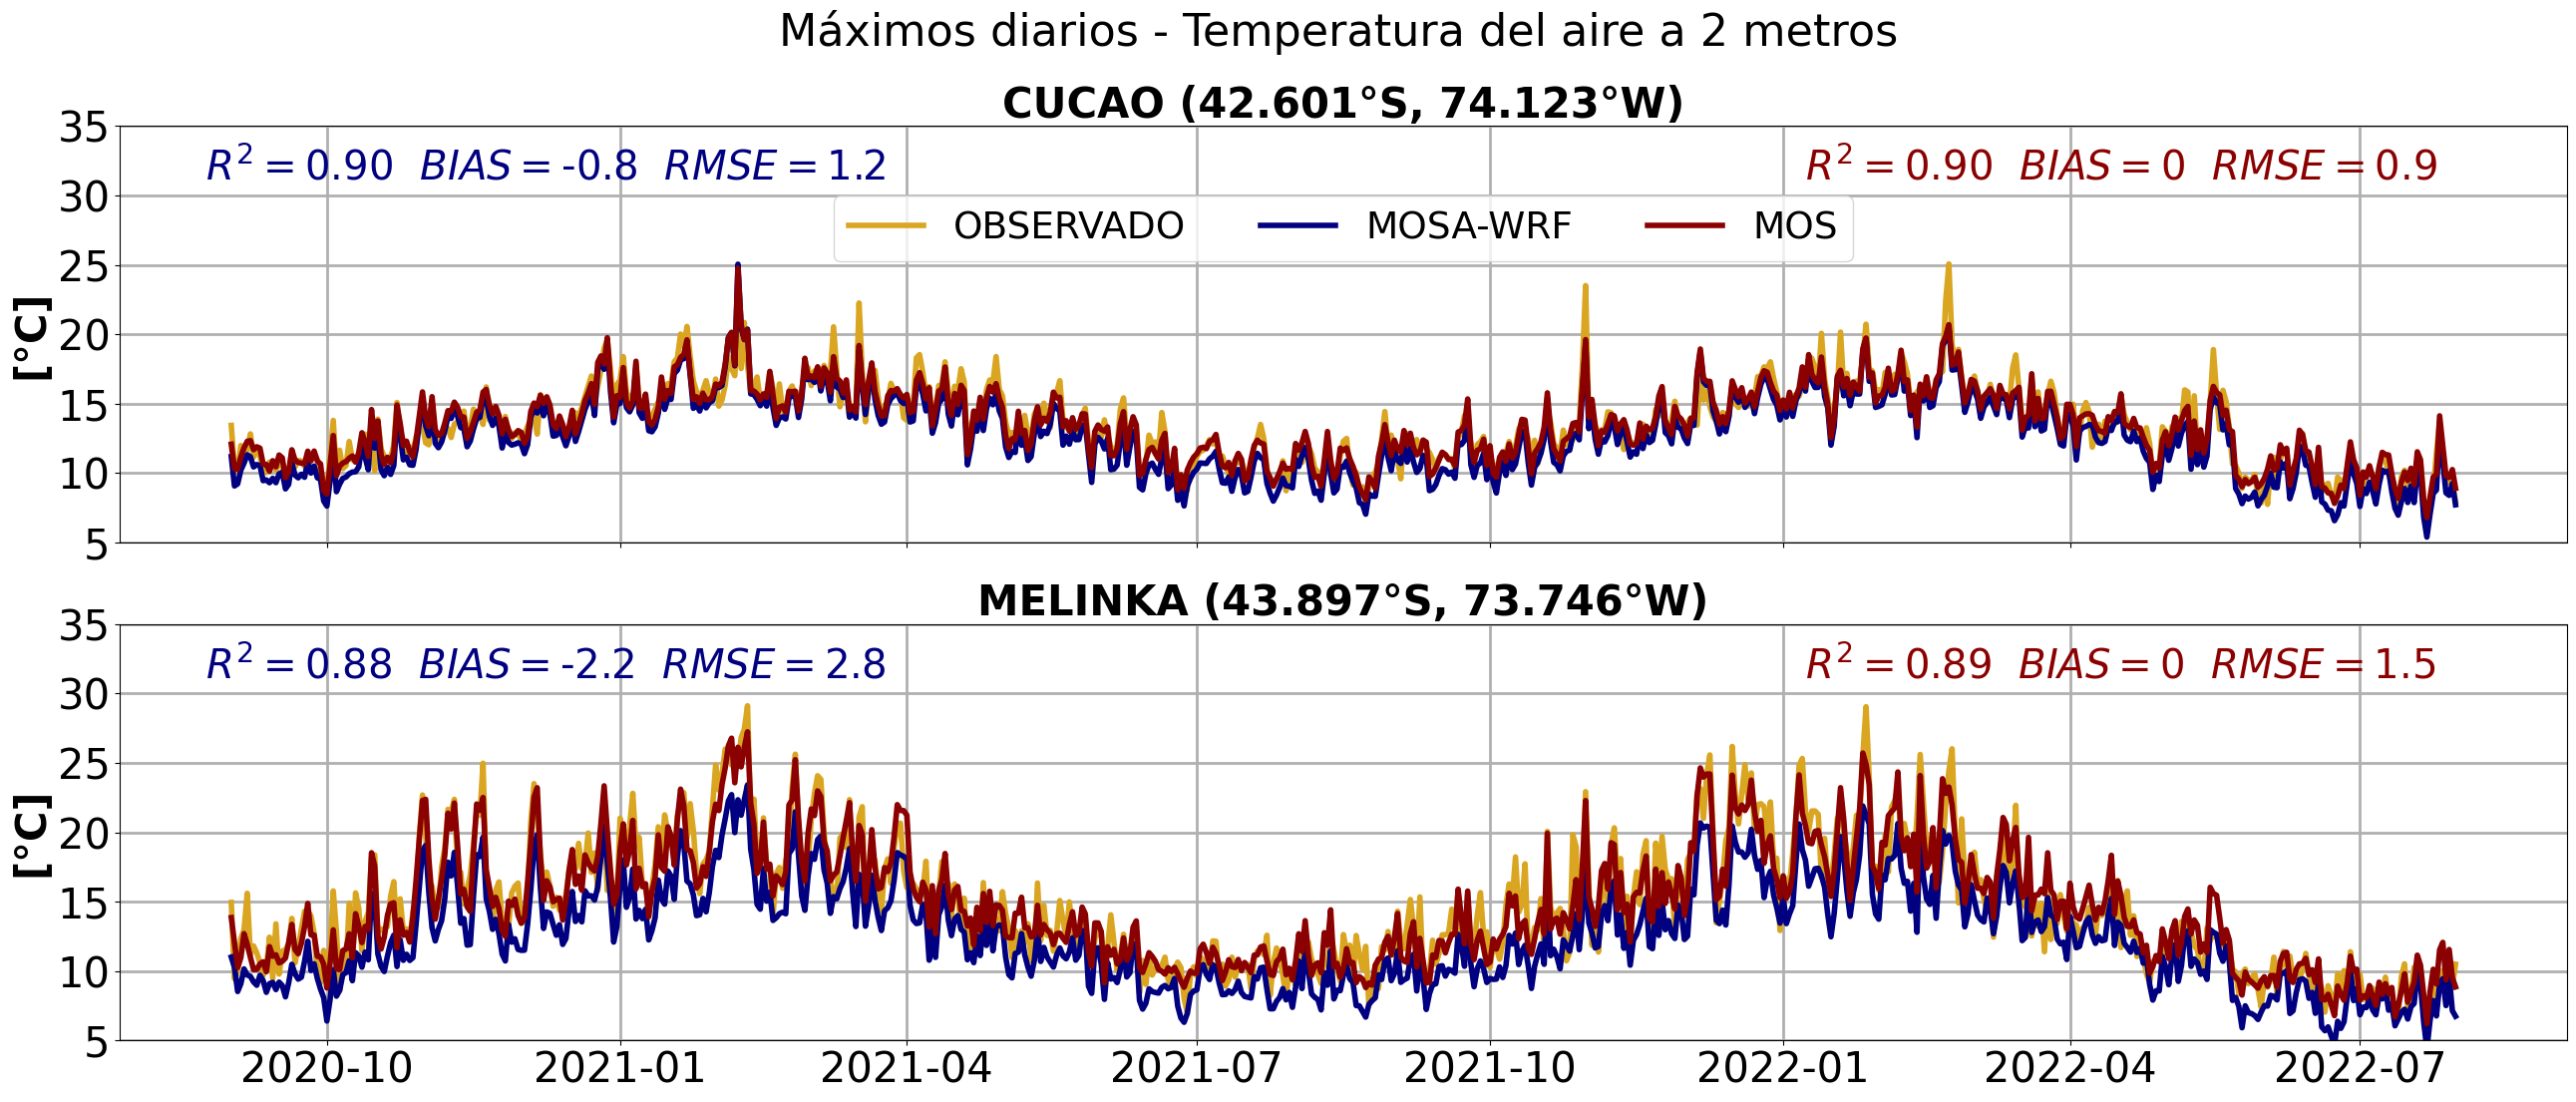

In [20]:
# SERIES DE TIEMPO PARA LOS MAXIMOS DIARIOS
# ======================================================================================
fig, ax = plt.subplots(2,figsize=(26,11), sharex=True)
fig.suptitle('Máximos diarios - Temperatura del aire a 2 metros',x=0.518,y=1.0,fontsize=32)
loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
# CUCAO
ax[0].plot(time,OBS_CUCAO,color='goldenrod',linewidth=4,label='OBSERVADO') #Observado
ax[0].plot(time,WRF_CUCAO,color='navy',linewidth=4,label='MOSA-WRF') #Simulado 
ax[0].plot(time,MOS_CUCAO,color='darkred',linewidth=4,label='MOS') #Diferencia
ax[0].legend(fontsize=27,ncol=3,bbox_to_anchor=(0.284, 0.629))
ax[0].set_ylabel('[°C]', fontsize = 30, weight='bold')
ax[0].set_ylim(5,35)
ax[0].yaxis.set_major_locator(loc)
ax[0].set_title('CUCAO (42.601°S, 74.123°W)',fontsize=30,x=0.5, y=1, weight='bold')
ax[0].grid(True,linewidth=2)
ax[0].annotate("$R^2=0.90$  $BIAS=0$  $RMSE=0.9$", xy=(0.6885, 0.87), xycoords=ax[0].transAxes,fontsize=29,color='darkred')
ax[0].annotate("$R^2=0.90$  $BIAS=$-$0.8$  $RMSE=1.2$",  xy=(0.035, 0.87), xycoords=ax[0].transAxes,fontsize=29,color='navy')

# MELINKA
ax[1].plot(time,OBS_MELINKA,color='goldenrod',linewidth=4) #Observado
ax[1].plot(time,WRF_MELINKA,color='navy',linewidth=4) #Simulado 
ax[1].plot(time,MOS_MELINKA,color='darkred',linewidth=4) #Diferencia
#ax[2].set_xlabel('Fecha', fontsize = 30, weight='bold')
ax[1].set_ylabel('[°C]', fontsize = 30, weight='bold')
ax[1].set_ylim(5,35)
ax[1].yaxis.set_major_locator(loc)
ax[1].set_title('MELINKA (43.897°S, 73.746°W)',fontsize=30,x=0.5, y=1, weight='bold')
ax[1].grid(True,linewidth=2)
ax[1].annotate("$R^2=0.89$  $BIAS=0$  $RMSE=1.5$", xy=(0.6885, 0.87), xycoords=ax[1].transAxes,fontsize=29,color='darkred')
ax[1].annotate("$R^2=0.88$  $BIAS=$-$2.2$  $RMSE=2.8$", xy=(0.035 , 0.87), xycoords=ax[1].transAxes,fontsize=29,color='navy')


fig.tight_layout()
plt.savefig("T2_max_MOS.png")

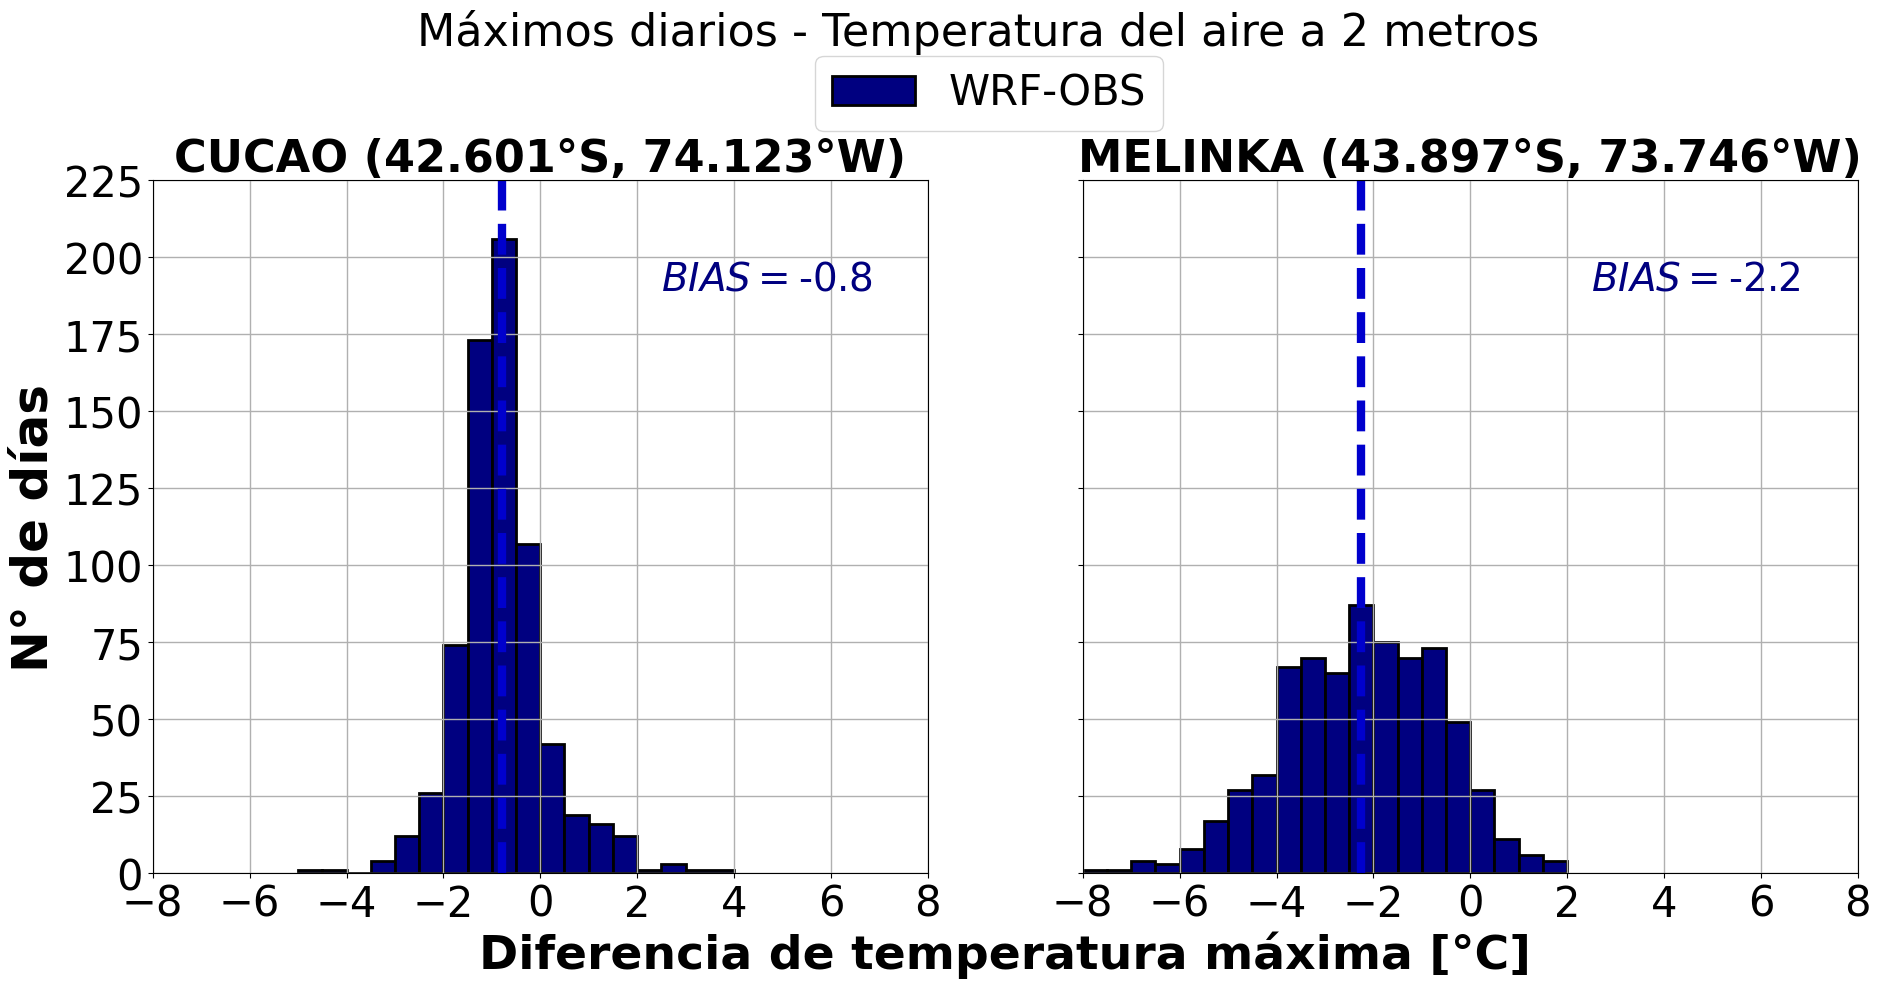

In [27]:
# HISTOGRAMA DE LAS DIFERENCIAS
intervalos = [-8, -6, -4, -2, 0, 2, 4, 6,8] #indicamos los extremos de los intervalos
intervalos_y = [0, 25, 50, 75, 100, 125, 150, 175, 200,225] #indicamos los extremos de los intervalos

# ======================================================================================  
fig, ax = plt.subplots(1,2,figsize=(22,9),sharey=True)
plt.subplot(1,2,1) # DIFERENCIA TEMPERATURA MÁXIMA
fig.suptitle('Máximos diarios - Temperatura del aire a 2 metros',x=0.5,y=1.07,fontsize=32)
plt.hist(WRF_CUCAO-OBS_CUCAO, bins=[-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,4],color = "navy",edgecolor='k',alpha=1,linewidth=2,label='WRF-OBS')
plt.axvline((WRF_CUCAO-OBS_CUCAO).mean(), color='mediumblue', linestyle='dashed', linewidth=6)
plt.ylabel('N° de días', fontsize=36, weight='bold')
plt.title('CUCAO (42.601°S, 74.123°W)',fontsize=32,weight='bold')
plt.ylim(0,225); plt.xlim(-8,8) ; plt.legend(bbox_to_anchor=(1.33, 1.21),fontsize=30,ncol=2)
plt.xticks(intervalos,fontsize=30);  plt.yticks(fontsize=30);  plt.grid(True,linewidth=1)
plt.yticks(intervalos_y); 
plt.text(2.5, 189.3, r'$BIAS=$-$0.8$',fontsize=28,color='navy')

plt.subplot(1,2,2) # DIFERENCIA TEMPERATURA MÁXIMA
plt.hist(WRF_MELINKA-OBS_MELINKA, bins=[-8,-7.5,-7,-6.5,-6,-5.5,-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2],color = "navy",edgecolor='k',alpha=1,linewidth=2)
plt.axvline((WRF_MELINKA-OBS_MELINKA).mean(), color='mediumblue', linestyle='dashed', linewidth=6)
plt.title('MELINKA (43.897°S, 73.746°W)',fontsize=32,weight='bold')
plt.xlabel('Diferencia de temperatura máxima [°C]', fontsize=34, weight='bold', horizontalalignment='center', x=-0.1)
plt.ylim(0,225); plt.xlim(-8,8) ;
plt.xticks(intervalos,fontsize=30);  plt.yticks(fontsize=30);  plt.grid(True,linewidth=1)
plt.yticks(intervalos_y);
plt.text(2.5, 189.3, r'$BIAS=$-$2.2$',fontsize=28,color='navy')

plt.savefig('hist_diferencias_Tmax1.png')

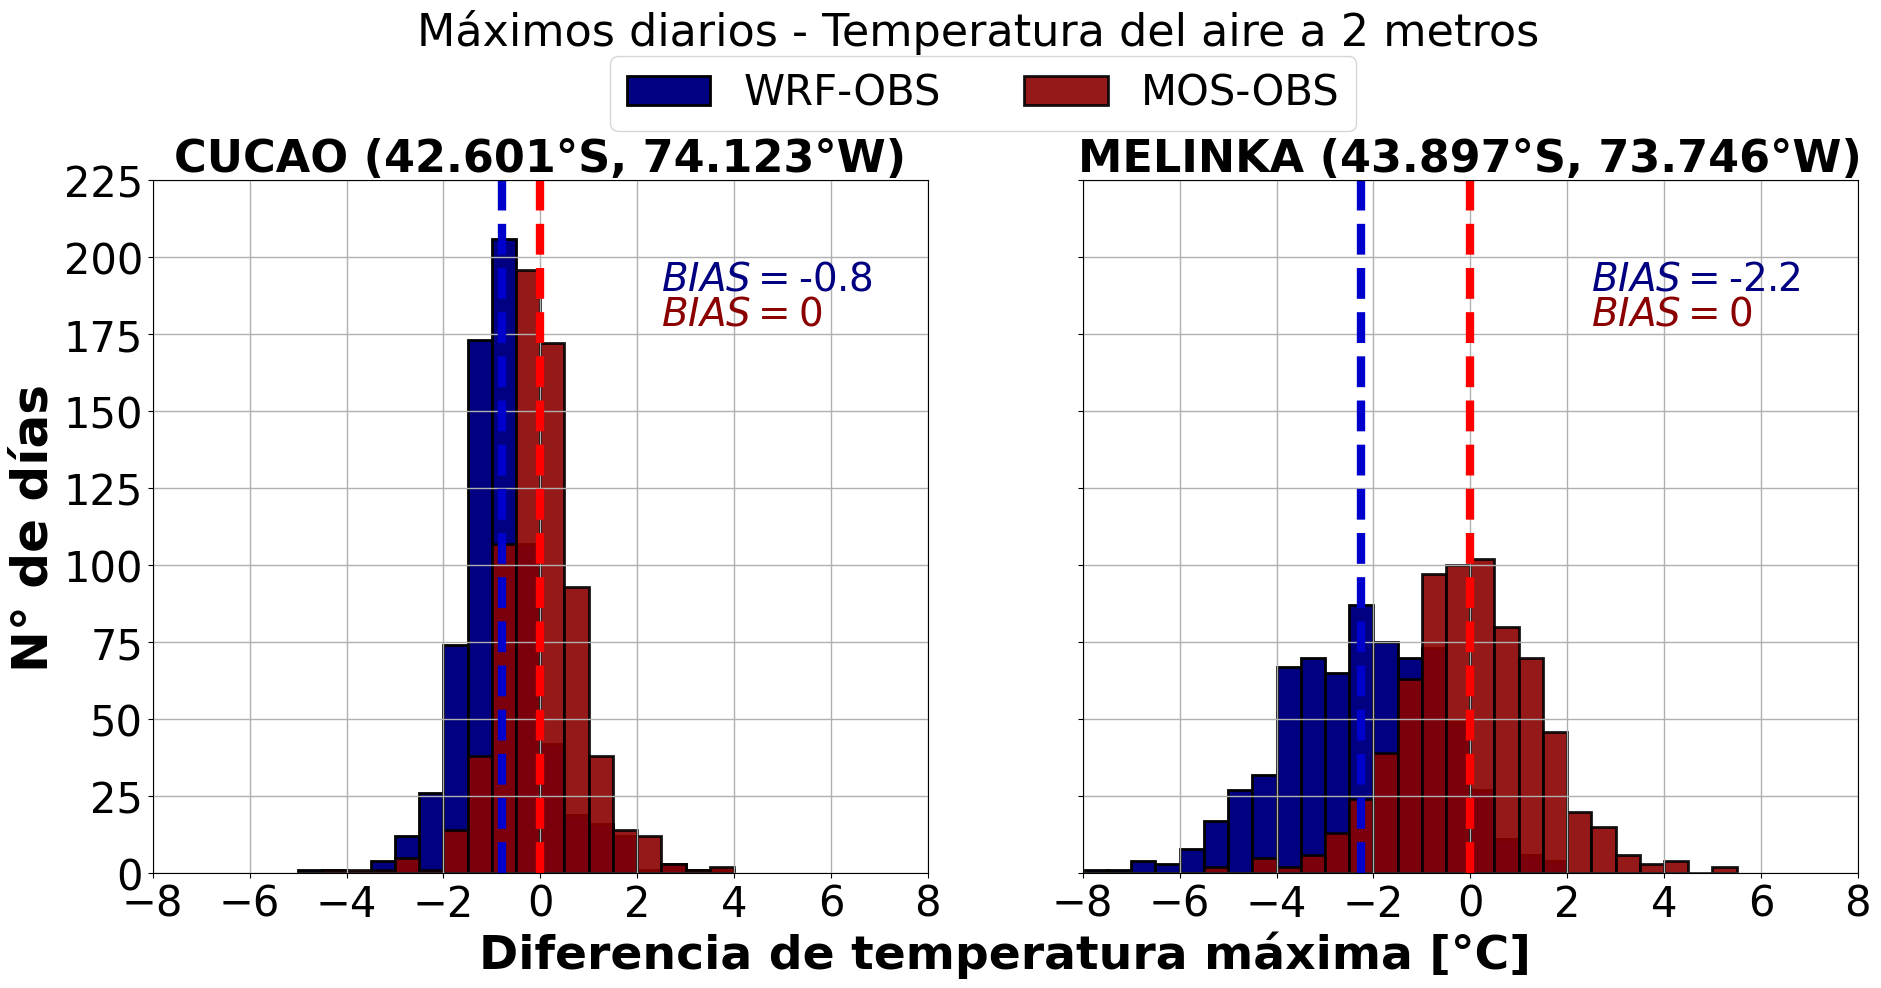

In [22]:
# HISTOGRAMA DE LAS DIFERENCIAS
intervalos = [-8, -6, -4, -2, 0, 2, 4, 6,8] #indicamos los extremos de los intervalos
intervalos_y = [0, 25, 50, 75, 100, 125, 150, 175, 200,225] #indicamos los extremos de los intervalos

# ======================================================================================  
fig, ax = plt.subplots(1,2,figsize=(22,9),sharey=True)
plt.subplot(1,2,1) # DIFERENCIA TEMPERATURA MÁXIMA
fig.suptitle('Máximos diarios - Temperatura del aire a 2 metros',x=0.5,y=1.07,fontsize=32)
plt.hist(WRF_CUCAO-OBS_CUCAO, bins=[-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,4],color = "navy",edgecolor='k',alpha=1,linewidth=2,label='WRF-OBS')
plt.axvline((WRF_CUCAO-OBS_CUCAO).mean(), color='mediumblue', linestyle='dashed', linewidth=6)
plt.hist(MOS_CUCAO-OBS_CUCAO, bins=[-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4],color = "darkred",edgecolor='k',alpha=0.90,linewidth=2,label='MOS-OBS')
plt.axvline((MOS_CUCAO-OBS_CUCAO).mean(), color='red', linestyle='dashed', linewidth=6)
plt.ylabel('N° de días', fontsize=36, weight='bold')
plt.title('CUCAO (42.601°S, 74.123°W)',fontsize=32,weight='bold')
plt.ylim(0,225); plt.xlim(-8,8) ; plt.legend(bbox_to_anchor=(1.58, 1.21),fontsize=30,ncol=2)
plt.xticks(intervalos,fontsize=30);  plt.yticks(fontsize=30);  plt.grid(True,linewidth=1)
plt.yticks(intervalos_y); 
plt.text(2.5, 189.3, r'$BIAS=$-$0.8$',fontsize=28,color='navy')
plt.text(2.5, 178, r'$BIAS=0$',fontsize=28,color='darkred')

plt.subplot(1,2,2) # DIFERENCIA TEMPERATURA MÁXIMA
plt.hist(WRF_MELINKA-OBS_MELINKA, bins=[-8,-7.5,-7,-6.5,-6,-5.5,-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2],color = "navy",edgecolor='k',alpha=1,linewidth=2,label='WRF-OBS')
plt.axvline((WRF_MELINKA-OBS_MELINKA).mean(), color='mediumblue', linestyle='dashed', linewidth=6)
plt.hist(MOS_MELINKA-OBS_MELINKA, bins=[-6,-5.5,-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5],color = "darkred",edgecolor='k',alpha=0.90,linewidth=2,label='MOS-OBS')
plt.axvline((MOS_MELINKA-OBS_MELINKA).mean(), color='red', linestyle='dashed', linewidth=6)
plt.title('MELINKA (43.897°S, 73.746°W)',fontsize=32,weight='bold')
plt.xlabel('Diferencia de temperatura máxima [°C]', fontsize=34, weight='bold', horizontalalignment='center', x=-0.1)
plt.ylim(0,225); plt.xlim(-8,8) ;
plt.xticks(intervalos,fontsize=30);  plt.yticks(fontsize=30);  plt.grid(True,linewidth=1)
plt.yticks(intervalos_y);
plt.text(2.5, 189.3, r'$BIAS=$-$2.2$',fontsize=28,color='navy')
plt.text(2.5, 178, r'$BIAS=0$',fontsize=28,color='darkred')

plt.savefig('hist_diferencias_Tmax.png')

In [23]:
## CUCAO WRF
print('BIAS (WRF): ', np.mean(WRF_CUCAO) - np.mean(OBS_CUCAO))
print('Correlación Pearson (WRF): ', np.corrcoef(WRF_CUCAO, OBS_CUCAO))
print('R-squared (WRF): ', (np.corrcoef(WRF_CUCAO, OBS_CUCAO))**2 )
print('RMSE (WRF): ', np.sqrt(mean_squared_error(WRF_CUCAO, OBS_CUCAO)))
print('COCIENTE STD (WRF): ', np.std(WRF_CUCAO ) / np.std(OBS_CUCAO) )
print('==========================================================')
print('==========================================================')
## CUCAO MOS
print('BIAS (MOS): ', np.mean(MOS_CUCAO) - np.mean(OBS_CUCAO))
print('Correlación Pearson (MOS): ', np.corrcoef(MOS_CUCAO, OBS_CUCAO) )
print('R-squared (MOS): ', (np.corrcoef(MOS_CUCAO, OBS_CUCAO))**2 )
print('RMSE (MOS): ', np.sqrt(mean_squared_error(MOS_CUCAO, OBS_CUCAO)))
print('COCIENTE STD (MOS): ', np.std(MOS_CUCAO) / np.std(OBS_CUCAO) )

BIAS (WRF):  -0.7955896752503584
Correlación Pearson (WRF):  [[1.         0.94645942]
 [0.94645942 1.        ]]
R-squared (WRF):  [[1.         0.89578544]
 [0.89578544 1.        ]]
RMSE (WRF):  1.2250378139690659
COCIENTE STD (WRF):  1.0409283594508936
BIAS (MOS):  0.0
Correlación Pearson (MOS):  [[1.         0.94862104]
 [0.94862104 1.        ]]
R-squared (MOS):  [[1.         0.89988188]
 [0.89988188 1.        ]]
RMSE (MOS):  0.8762918728507565
COCIENTE STD (MOS):  0.9486210414782648


In [24]:
## MELINKA WRF
print('BIAS (WRF): ', np.mean(WRF_MELINKA) - np.mean(OBS_MELINKA))
print('Correlación Pearson (WRF): ', np.corrcoef(WRF_MELINKA,OBS_MELINKA))
print('R-squared (WRF): ', (np.corrcoef(WRF_MELINKA, OBS_MELINKA))**2 )
print('RMSE (WRF): ', np.sqrt(mean_squared_error(WRF_MELINKA, OBS_MELINKA)))
print('COCIENTE STD (WRF): ', np.std(WRF_MELINKA) / np.std(OBS_MELINKA))
print('==========================================================')
print('==========================================================')
## MELINKA MOS
print('BIAS (MOS): ', np.mean(MOS_MELINKA) - np.mean(OBS_MELINKA))
print('Correlación Pearson (MOS): ', np.corrcoef(MOS_MELINKA, OBS_MELINKA))
print('R-squared (MOS): ', (np.corrcoef(MOS_MELINKA, OBS_MELINKA))**2 )
print('RMSE (MOS): ', np.sqrt(mean_squared_error(MOS_MELINKA, OBS_MELINKA)))
print('COCIENTE STD (MOS): ', np.std(MOS_MELINKA) / np.std(OBS_MELINKA) )

BIAS (WRF):  -2.246296309585121
Correlación Pearson (WRF):  [[1.         0.93655772]
 [0.93655772 1.        ]]
R-squared (WRF):  [[1.         0.87714037]
 [0.87714037 1.        ]]
RMSE (WRF):  2.773815976655583
COCIENTE STD (WRF):  0.833797182107114
BIAS (MOS):  -1.7763568394002505e-15
Correlación Pearson (MOS):  [[1.         0.94525773]
 [0.94525773 1.        ]]
R-squared (MOS):  [[1.         0.89351217]
 [0.89351217 1.        ]]
RMSE (MOS):  1.4538399468920566
COCIENTE STD (MOS):  0.9452577282745488
